In [1]:
using Ai4EComponentLib
using Ai4EComponentLib.CompressedAirSystem
using ModelingToolkit, DifferentialEquations
using Plots

In [2]:
stateEquation(p, ρ, T) = p - ρ * T * 287.11
@register_symbolic stateEquation(p, ρ, T) #状态方程

@connector function FlowPort2(; name, T=330)
    sts = @variables begin
        p(t) = 1.013e5
        T(t) = T
        (qm(t)=0, [connect = Flow])
        (ρ(t)=12, [connect = Stream])
        (μ(t)=1.819e-1, [connect = Stream])
        (qv(t)=0, [connect = Stream])
    end
    eqs = [
        0 ~ stateEquation(p, ρ, T)
        μ ~ 1.819e-1
        qv ~ qm / ρ
    ]
    ODESystem(eqs, t, sts, []; name=name)
end

FlowPort2 (generic function with 1 method)

In [49]:
function TransitionPipe2(; name, n=10, f=0.011, D=1.0, L=1.0, T=300, p0= 1e5 * ones(n), qm0=zeros(n))

    RT = 287.11 * T
    A0 = pi / 4 * D^2
    c10 = RT / A0
    c20 = c10 * f / 2 / D

    @named inlet = FlowPort2()
    @named outlet = FlowPort2()

    @parameters begin
        A = A0
        c1 = c10
        c2 = c20
        dx = L / n
        f = f

        U = 1.68
    end
    

    @variables (qm(t))[1:n] (p(t))[1:n+1] (tm(t))[1:n+1]

    initialValue = Dict(qm[i] => qm0[i] for i = 1:n)
    merge!(initialValue, Dict(p[i] => p0[i] for i = 1:n))
    merge!(initialValue, Dict(tm[i] => 330 for i = 1:n))

    eqs_continous = [
        ∂(p[i]) ~ c1 * (qm[i-1] - qm[i]) / dx
        for i = 2:n
    ]
    
    eqs_continous_tm = [
        tm[i] ~ tm[i - 1] - U * 2 * pi * D * dx * (tm[i - 1] - T)
        for i = 2:n
    ]

    eqs_continous_tm2 = [
        # ∂(tm[i]) ~ tm[i] - T
        # for i = 2:n
    ]

    eqs_momentum = [
        ∂(qm[i]) ~ (c1 * qm[i]^2 / (0.5 * (p[i+1] + p[i]))^2 - A) * (p[i+1] - p[i]) / dx + c1 * qm[i] / (0.5 * (p[i+1] + p[i])) * (qm[i-1] - qm[i+1]) / dx - c2 * qm[i] * abs(qm[i]) / (0.5 * (p[i+1] + p[i]))
        for i = 2:n-1
    ]

    bd = [
        tm[1] ~ inlet.T
        tm[n+1] ~ outlet.T
        p[1] ~ inlet.p
        p[n+1] ~ outlet.p
        qm[n] ~ -outlet.qm
        qm[1] ~ inlet.qm
        ∂(qm[1]) ~ (c1 * qm[1]^2 / (0.5 * (p[2] + p[1]))^2 - A) * (p[2] - p[1]) / dx + c1 * qm[1] / (0.5 * (p[2] + p[1])) * (3 * qm[1] - 4 * qm[2] + qm[3]) / dx - c2 * qm[1] * abs(qm[1]) / (0.5 * (p[2] + p[1]))
        ∂(qm[n]) ~ (c1 * qm[n]^2 / (0.5 * (p[n+1] + p[n]))^2 - A) * (p[n+1] - p[n]) / dx + c1 * qm[n] / (0.5 * (p[n+1] + p[n])) * (-3 * qm[n] + 4 * qm[n-1] - qm[n-2]) / dx - c2 * qm[n] * abs(qm[n]) / (0.5 * (p[n+1] + p[n]))
    ]
    compose(ODESystem([eqs_continous; eqs_momentum; bd; eqs_continous_tm; eqs_continous_tm2], t; name=name, defaults=initialValue), inlet, outlet)
end

TransitionPipe2 (generic function with 1 method)

In [106]:
f=0.05                  # Friction resistance coefficient
n2 = 120                 # Number of nodes
D2 = 0.4                # Pipe diameter
L2 = 600                # length
R2 = 3000               # Resistance coefficient
T2 = 300                # Temperature
qm02 = 10 * ones(n2)    # Initial mass flow rate
p02 = range(6e5,5e5,length=n2)  #initial pressure

@named transPipe = TransitionPipe2(n=n2, D=D2, L=L2, T=T2, p0=p02, qm0=qm02, f=f)
# @named transPipe2 = TransitionPipe2(n=n2, D=D2, L=L2, T=T2, p0=p02, qm0=qm02, f=f)
# @named transPipe3 = TransitionPipe2(n=n2, D=D2, L=L2, T=T2, p0=p02, qm0=qm02, f=f)

inletBoundary = Dict(
    "p" => 5.0e5,
    "T" => 300,
)

outletBoundary = Dict(
    "T" => 300,
    "p" => 4e5,
)

@named inletSource = Source(boundary=inletBoundary)
@named outletSource = Source(boundary=outletBoundary)

┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40


┌ Warning: source contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: source contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40


Model outletSource with 5 (6) equations
States (6):
  source₊T(t) [defaults to 300]
  source₊p(t) [defaults to 101300.0]
  source₊qm(t) [defaults to 0]
  source₊ρ(t) [defaults to 1.2]
⋮
Parameters (0):

In [107]:
eqs = [
    connect(transPipe.inlet, inletSource.source),
    # connect(transPipe.outlet, transPipe2.inlet),
    # connect(transPipe2.outlet, transPipe3.inlet),
    connect(transPipe.outlet, outletSource.source)
]

2-element Vector{Equation}:
 connect(transPipe.inlet, inletSource.source)
 connect(transPipe.outlet, outletSource.source)

In [108]:
@named eq_model = ODESystem(eqs, t)
@named model = compose(
    eq_model,
    inletSource, outletSource,
    transPipe, #transPipe2, transPipe3
)

sys = structural_simplify(model)
prob = ODEProblem(sys, [], (0, 3))

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 3)
u0: 243-element Vector{Float64}:
 599159.6638655462
 598319.3277310925
 597478.9915966387
 596638.6554621849
 595798.319327731
 594957.9831932773
 594117.6470588235
 593277.3109243697
 592436.974789916
 591596.6386554622
      ⋮
     10.0
     10.0
     10.0
     10.0
     10.0
      1.2
      1.2
     12.0
     12.0

In [109]:
sol = solve(prob, Rodas4())

retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 139-element Vector{Float64}:
 0.0
 1.0e-6
 1.1e-5
 0.00011099999999999999
 0.0011109999999999998
 0.00325202198655067
 0.00565110183688725
 0.008258611845350797
 0.011945839715567175
 0.016141982673121873
 ⋮
 2.643900825946147
 2.68601755571221
 2.729698174581436
 2.7750318104347467
 2.822298850015949
 2.8717263851616464
 2.9238674071588466
 2.979653845463878
 3.0
u: 139-element Vector{Vector{Float64}}:
 [599159.6638655462, 598319.3277310925, 597478.9915966387, 596638.6554621849, 595798.319327731, 594957.9831932773, 594117.6470588235, 593277.3109243697, 592436.974789916, 591596.6386554622  …  10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 5.804976025449015, 4.643980820359213, 5.804976025449015, 4.643980820359212]
 [599159.6636935469, 598319.327731093, 597478.9915966394, 596638.6554621856, 595798.3193277317, 594957.983193278, 594117.6470588242, 593277.3109243704, 592436.9747899167, 591596.6386554629  …  1

In [110]:
sol[transPipe.tm]

139-element Vector{Vector{Float64}}:
 [300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0  …  300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
 [300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0  …  300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
 [300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0  …  300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
 [300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0  …  300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
 [300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0  …  300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
 [300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0  …  300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
 [300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0  …  300.0, 300.0, 300.

┌ Info: Saved animation to /Users/jerell/Repos/jigsaw/engine/anim_p_fps30.gif
└ @ Plots /Users/jerell/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/jerell/Repos/jigsaw/engine/anim_p_fps30.gif")
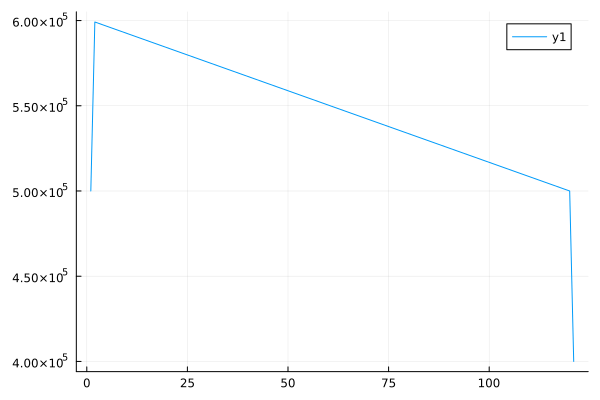

In [111]:
anim = @animate for i ∈ sol[transPipe.p]
    plot(i)
end
gif(anim, "anim_p_fps30.gif", fps = 30)

┌ Info: Saved animation to /Users/jerell/Repos/jigsaw/engine/anim_qm_fps30.gif
└ @ Plots /Users/jerell/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/jerell/Repos/jigsaw/engine/anim_qm_fps30.gif")
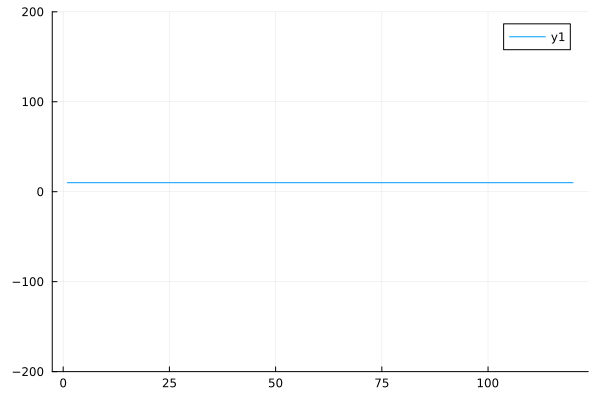

In [112]:
anim = @animate for i ∈ sol[transPipe.qm]
    plot(i, ylim=(-200, 200))
end
gif(anim, "anim_qm_fps30.gif", fps = 30)


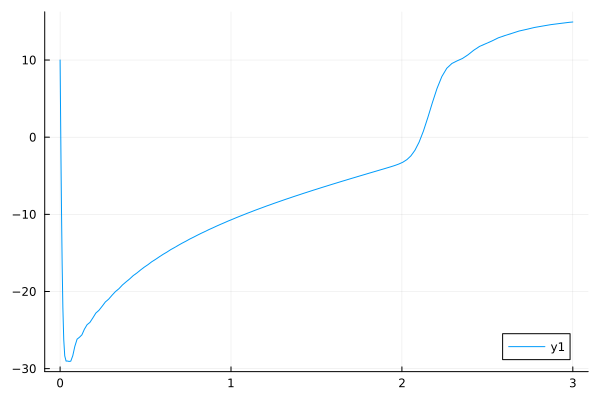

In [113]:
plot(sol.t, map(x -> x[1] ,sol[transPipe.qm]))

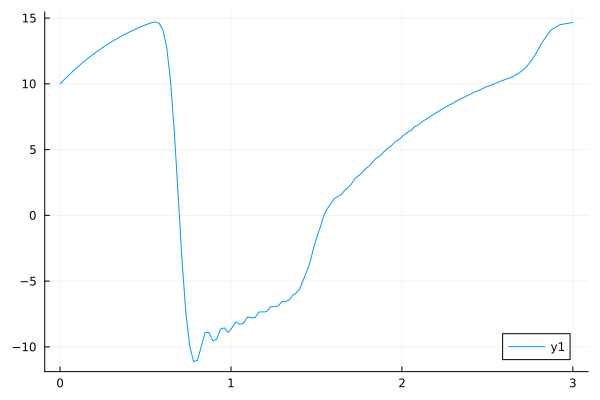

In [114]:
plot(sol.t, map(x -> x[40] ,sol[transPipe.qm]))

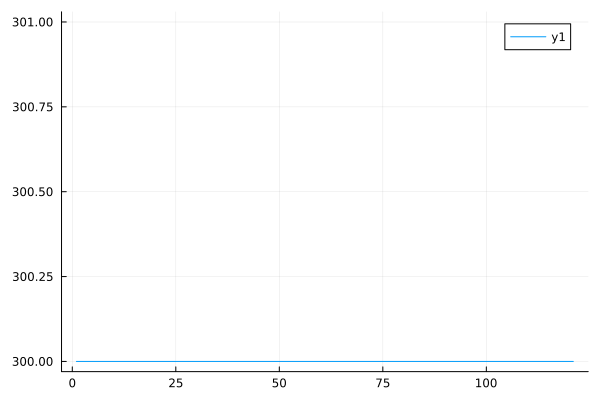

In [115]:
plot(sol[transPipe.tm][1])